In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline
from decimal import Decimal
import warnings
warnings.filterwarnings("ignore")
import pickle
from keras.models import model_from_json
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import Normalizer, MinMaxScaler

Using TensorFlow backend.
/Users/DaveSomo/anaconda3/envs/deeplearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
# df=pd.read_csv('C:\\Users\\lengada1\\NCSU\\ten_skus.csv')
# df=pd.read_csv('C:\\Users\\lengada1\\NCSU\\ten_skus.csv')
df=pd.read_csv('./ten_skus.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.weekday_name

day_dummy=pd.get_dummies(df.Day)
df=pd.concat([df,day_dummy],axis=1)
df.drop(['Day','Date','Luxury','High_Var'],inplace=True,axis=1)

#This moving average will need to be corrected when id changes. Overlapping now.
for sku in range(10):  #TODO Is the loop needed?
    df["Mov_avg"]=df['Sales'].rolling( window=7).mean().shift(1)

In [3]:
df.head(20)

,id,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Mov_avg
0,1,2,0,0,0,0,1,2013,1,0,0,0,0,0,1,0,NaN
1,1,3,5530,668,1,0,1,2013,1,0,0,0,0,0,0,1,NaN
2,1,4,4327,578,1,0,1,2013,1,0,0,0,0,1,0,0,NaN
3,1,5,4486,619,1,0,1,2013,1,1,0,0,0,0,0,0,NaN
4,1,6,4997,635,1,0,1,2013,1,0,0,1,0,0,0,0,NaN
5,1,7,0,0,0,0,1,2013,1,0,0,0,1,0,0,0,NaN
6,1,1,7176,785,1,1,1,2013,1,0,1,0,0,0,0,0,NaN
7,1,2,5580,654,1,1,1,2013,1,0,0,0,0,0,1,0,3788.000000
8,1,3,5471,626,1,1,1,2013,1,0,0,0,0,0,0,1,4585.142857
9,1,4,4892,615,1,1,1,2013,1,0,0,0,0,1,0,0,4576.714286


In [4]:
sequence_length=10

def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0] #number of rows
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop,:]

In [5]:
X=df.loc[df['id']==1]
sequence_cols = ['id','Sales','Customers','Open','Promo','SchoolHoliday','Year','Month','Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday']
# sequence_cols = ['id','DayOfWeek','Sales','Customers','Open','Promo','SchoolHoliday','Year']
# generator for the sequences
seq_gen = (list(gen_sequence(X[X['id']==id], sequence_length, sequence_cols)) 
           for id in X['id'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)


In [6]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [7]:
# generate labels or Ys  Note: this array will start at record = sequence_length
label_gen = [gen_labels(X[X['id']==id], sequence_length, ['Sales']) 
             for id in X['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array[0]

array([4881.], dtype=float32)

In [8]:
seq_array.shape

(932, 10, 15)

In [9]:
label_array.shape

(932, 1)

In [10]:
# Epochs=50
# Try out with: only dayofweek, only dummies, both

In [12]:
dayOfBreak
dummies
low_epoch=10
window
layer

def experiment_LSTM():
    model = Sequential()
    model.add(LSTM(input_shape=(sequence_length, nb_features),units=16,return_sequences=True))
    model.add(LSTM(input_shape=(sequence_length, nb_features),units=4,return_sequences=False))
    model.add(Dense(units=1,activation='linear'))
    model.compile(loss="mse", optimizer="sgd", metrics=['mae','mse'])
    
    model.fit(seq_array, label_array, epochs=25, batch_size=32, verbose=0)



nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

# Build layers
model = Sequential()
#model.add(LSTM(input_shape=(sequence_length, nb_features),units=21,return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(input_shape=(sequence_length, nb_features),units=16,return_sequences=True))
model.add(LSTM(input_shape=(sequence_length, nb_features),units=4,return_sequences=False))
#model.add(Dense(units=2))
model.add(Dense(units=1,activation='linear'))
model.compile(loss="mse", optimizer="sgd", metrics=['mae','mse'])

model.fit(seq_array, label_array, epochs=25, batch_size=32, verbose=0)
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=1)

print('Mean Abs Error: {}'.format(scores[1],0)  )
print('MSE: {}'.format(scores[2]/10000000,0)  )


prediction=model.predict(seq_array, verbose=1)

932/932 [==============================] - 5s 6ms/step
Mean Abs Error: 1486.2282222371246
MSE: 0.40472827417640705
932/932 [==============================] - 0s 526us/step


In [ ]:
def experiment_LSTM():
    dayOfWeek

In [97]:
#David S.  Stop here.  Everything else below is subject to change. Focus on modeling only 1 SKU for efficiency reasons. 
#Convert dataframe to:
   #1) with day of week dummies
   #2) without dummies

# these last two are optional
   #3) possibly add moving avg (but should an LSTM need this?  probably not)
   #4) possibly add lags  (but again LSTMs shouldn't need this)

[10366587.870074626, 2473.806804708389, 10366587.870074626]

In [48]:
# Day of week dummies
df_weekdays = X[["id","Sales", "Friday","Monday", "Saturday", "Sunday", "Thursday", "Tuesday","Wednesday"]]

# Without dummies
df_no_weekdays = X[["id","Sales", "DayOfWeek"]]

In [49]:
df_no_weekdays.head(10)

,id,Sales,DayOfWeek
0,1,0,2
1,1,5530,3
2,1,4327,4
3,1,4486,5
4,1,4997,6
5,1,0,7
6,1,7176,1
7,1,5580,2
8,1,5471,3
9,1,4892,4


In [10]:
y1=X.iloc[sequence_length:,].reset_index(drop=True)
y1=y1.loc[:,'Sales']
#y1.shape

pred2 = pd.DataFrame(prediction)
pred3=pd.concat([pred2,y1],axis=1)
#pred3.head()

plt.plot(pred3.iloc[:100,0]   ) 
plt.plot(pred3.iloc[:100,1]   ) 

#plt.show()

NameError: name 'sequence_length' is not defined

In [32]:
pred3.iloc[:10,:]

,0,Sales
0,4931.867188,5580
1,5322.408691,5471
2,5322.408691,4892
3,5322.408691,4881
4,5322.408691,4952
5,5322.408691,0
6,7385.768555,4717
7,5322.408691,3900
8,5322.408691,4008
9,5322.408691,4044


In [187]:
#pred2.to_csv('~/Desktop/ML/predictions.csv')

In [16]:
# BUILD REGULAR NON-LSTM, RNN MODEL

X=pd.read_csv('C:\\Users\\lengada1\\NCSU\\ten_skus.csv')
#X.DayOfWeek =X.DayOfWeek.astype(str)
X=X.iloc[0:,:]

y=X['Sales']
Xs=X[['id','Open','Promo','SchoolHoliday']]
for obs in range(1,8):
    Xs["Sales_T"+str(obs)]=X['Sales'].shift(obs)
#for obs in range(1,8):
#    Xs["Customers_T"+str(obs)]=X['Sales'].shift(obs)
Xs['Mov_avg']=pd.rolling_mean(X['Sales'], window=7).shift(1)

import datetime


Xs['Date'] = pd.to_datetime(X['Date'])
Xs['Year'] = Xs['Date'].dt.year
Xs['Month'] = Xs['Date'].dt.month
Xs['Day'] = Xs['Date'].dt.weekday_name


day_dummy=pd.get_dummies(Xs.Day)
Xs=pd.concat([Xs,day_dummy],axis=1)
Xs.drop(['Day','Date'],inplace=True,axis=1)


y=y[7:]
y.reset_index(drop=True, inplace=True)
Xs=Xs.iloc[7:,:]
Xs.reset_index(drop=True, inplace=True)
Xs.iloc[:7,:]


,id,Open,Promo,SchoolHoliday,Sales_T1,Sales_T2,Sales_T3,Sales_T4,Sales_T5,Sales_T6,...,Mov_avg,Year,Month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,1,1,1,7176.0,0.0,4997.0,4486.0,4327.0,5530.0,...,3788.000000,2013,1,0,0,0,0,0,1,0
1,1,1,1,1,5580.0,7176.0,0.0,4997.0,4486.0,4327.0,...,4585.142857,2013,1,0,0,0,0,0,0,1
2,1,1,1,1,5471.0,5580.0,7176.0,0.0,4997.0,4486.0,...,4576.714286,2013,1,0,0,0,0,1,0,0
3,1,1,1,1,4892.0,5471.0,5580.0,7176.0,0.0,4997.0,...,4657.428571,2013,1,1,0,0,0,0,0,0
4,1,1,0,0,4881.0,4892.0,5471.0,5580.0,7176.0,0.0,...,4713.857143,2013,1,0,0,1,0,0,0,0
5,1,0,0,0,4952.0,4881.0,4892.0,5471.0,5580.0,7176.0,...,4707.428571,2013,1,0,0,0,1,0,0,0
6,1,1,0,0,0.0,4952.0,4881.0,4892.0,5471.0,5580.0,...,4707.428571,2013,1,0,1,0,0,0,0,0


In [21]:
y.loc[800:]

800     4748
801     4057
802     3909
803        0
804     3565
805     3547
806     3531
807     3932
808     4005
809     5208
810        0
811     6714
812     6206
813     6816
814     6574
815        0
816     6709
817        0
818        0
819     4163
820     4194
821     3467
822     3549
823     4173
824        0
825     5377
826     4648
827     4110
828     4116
829     4718
        ... 
9383    6317
9384    5915
9385    5120
9386       0
9387    6143
9388    5476
9389    4865
9390    4871
9391    5747
9392    4636
9393       0
9394    6757
9395    7491
9396    6423
9397    6275
9398    5356
9399    5761
9400       0
9401    6111
9402    6479
9403    5561
9404    6401
9405    6152
9406    4713
9407       0
9408    7212
9409    6140
9410    5524
9411    6186
9412    7185
Name: Sales, Length: 8613, dtype: int64

In [ ]:
model = Sequential()
model.add(Dense(20, input_dim=Xs.shape[1], activation='linear'))
model.add(Dense(20, activation='relu'))
model.add(Dense(40, activation='linear'))
model.add(Dense(10, activation='relu'))
#model.add(Dense(10, activation='linear'))
model.add(Dense(1, activation='linear'))
# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])
# Fit the model
model.fit(Xs.loc[800:935,:], y.loc[800:935], epochs=700, batch_size=20, verbose=0)
# evaluate the model
scores = model.evaluate(Xs.l, y)
#print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

print("%s: %.0f"%  (model.metrics_names[1], scores[1]))
print("%s: %.1f"%  (model.metrics_names[2], scores[2]/10000000))

prediction2=model.predict(Xs, verbose=0)

In [168]:
print('MAE 20: 171, 201')
print('MAE batch 50: 284, 312, 353')


MAE 20: 236, 238, 316, 322
MAE batch 50: 284, 312, 353


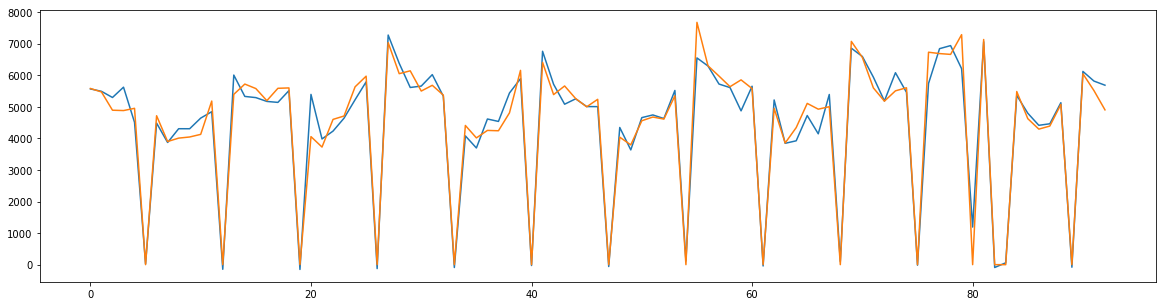

In [278]:
pred2=pd.DataFrame(prediction2)
pred3=pd.concat([pred2,y],axis=1)
plt.figure(figsize=(20,5))
plt.plot(pred3.iloc[:,0]   ) 
plt.plot(pred3.iloc[:,1]   )

#plt.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("NCSU_DC.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NCSU_DC.h5")
print("Saved model to disk")

In [ ]:
# load json and create model
json_file = open('NCSU_DC.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("NCSU_DC.h5")
print("Loaded model from disk")

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])
score = loaded_model.evaluate(Xs, y, verbose=0)
print("%s: %.0f"%  (loaded_model.metrics_names[1], score[1]))
print("%s: %.1f"%  (loaded_model.metrics_names[2], score[2]/10000000))

In [ ]:
#   USEFUL CODE FOR LATER
#data_train['Year'] = data_train['Date'].apply(lambda x: int(x[:4]))
#data_train['Month'] = data_train['Date'].apply(lambda x: int(x[5:7]))
#data_train['StateHoliday'] = data_train['StateHoliday'].replace(0, '0')
#data_train["HolidayBin"] = data_train['StateHoliday'].map({"0": 0, "a": 1, "b": 1, "c": 1})
#data_train.StateHoliday.unique()

#average_customers_per_month = data_train.groupby('Month')['Customers'].mean()
#average_sales_per_month = data_train.groupby('Month')['Sales'].mean()